## IMPORTING LIBRARIES AND DATASET DOWNLOAD

In [2]:
# System Libraries
import os
from pathlib import Path
import tarfile
from IPython.display import Audio, clear_output

# Handling Data Libraries
import pandas as pd
import numpy as np

# Plot Libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files.
'''
import librosa
import librosa.display
'''

# ML libraries
'''
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
'''

# DL libraries
'''
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
'''

# Handling warnings library
'''
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
''';

The dataset is distributed on this webpage https://sail.usc.edu/iemocap/ under request, after the request is accepted they provide you a download link that expire in 48 hours therefore we uploaded a lighter copy of it on kaggle as a private dataset (only the files we were interested in), therefore to run the following cell you just have to ask the access to Riccardo Paolini, we will provide you the access as soon as possible, then you have to download a ***kaggle.json*** file from kaggle to do that follow this steps:
- go to https://www.kaggle.com/
- sign up/in to your account on kaggle
- click on your propic in the top right corner
- click "Your Profile -> Account -> Create New API Token"

after this steps the download of your ***kaggle.json*** file should have started.
By running the following cell you are requested to upload the ***kaggle.json*** therefore the download of the private dataset should start.

## DATASET DESCRIPTION (Copy Paste of the README.txt file of the dataset)

Thank you for your interest in the USC_IEMOCAP database.  The USC_IEMOCAP database contains audio, transcriptions, video, and motion-capture(MoCap) recordings of dyadic mixed-gender pairs of actors.  There are five sessions in the database (ten actors total). For complete information about IEMOCAP please refer to:

Busso, Carlos et al.  "IEMOCAP: Interactive emotional dyadic motion capture database."  Journal of Language Resources and Evaluation.  Volume 42, Number 4.  pp. 335-359.  2008

as well as our website: http://sail.usc.edu/iemocap/

The recorded dialogs are either improvisations of affective scenarios, or performances of theatrical scripts. They have been manually segmented into utterances. Each utterance from either of the actors in the interaction has been evaluated categorically over the set of: {angry, happy, sad, neutral, frustrated, excited, fearful, surprised, disgusted, other} by at least three different annotators, and dimensionally over the axes of: valence (positive vs. negative); activation (calm vs. excited); and dominance (passive vs. aggressive) by at least two different annotators. 

In each recording of a session only one actor wears MoCap markers while both are being recorded by microphones and cameras. Thus there are available MoCap data (facial expression, head and hand movement) for one actor per recording, while there are wavefile and videos for both actors. The naming convention regarding the data is e.g., Ses01F_impro01 while indicates Session1, where the Female actor is wearing the markers and actors are performing improvisation 1. The release contains two formats: dialog format which contains data from the entire dyadic interaction and the sentence format where the data per dialog (recording) have been further segmented into utterances (see folders SessionX/dialog and SessionX/sentences respectively). For the utterance format the naming is as follows: Ses01F_impro01_M000 indicates first session, Female actor is wearing markers, actors are performing improvisation 1 and this is the first utterance of the Male actor. The timing of the sentences in each dialog can be found in the lab files in SessionX/dialog/lab

The MoCap data can be found in either dialog format or sentece format in the corresposding folders. The MOCAP_rotated folder contains motion-capture data rotated and translated such that the central nose marker always represents the (0,0,0) xyz-tuple. The MoCap data are in .txt files where each line is a frame number and each column is a marker coordinate. Please consult the headers of the MoCap files and the diagram of the facial markers (Documentation/FIVE_face_markers2.png) to see the correspondence between marker positions and marker names. The hand mocap data is in MOCAP_hand folder, while the information of head translation (x,y,z) and head rotation (yaw, pitch, roll) is in MOCAP_head folder. 

We are also distributing wavefiles (sentence and dialog format), the videos of the recordings (SessionX/dialog/avi/), and transcriptions of the dialogs (SessionX/dialog/transcriptions/). For the segmented utterances we are also providing the results of forced alignment which contain detail phoneme, syllable and word level timing information (SessionX/sentences/ForcedAlignment/).

The evaluations (emotional annotations) for each recording and each uterance are contained in folder SessionX/dialog/Evaluation/. Each file provides the detailed evaluation reports for the categorical evaluators (e.g., C-E1), the dimensional evaluators (e.g., A-E1), and the self-evaluatiors (e.g., C-F1 or C-M1, A-F1 or A-M1). The utterance-level information can be found in the first line of an utterance summary.  The first entry represents the start and end times for the utterance.  The second entry is the utterance name (e.g., Ses01_impro01_F003).  The third entry is the ground truth (if no majority ground truth could be assigned, the ground truth is labeled xxx).  The final engry is the average dimensional evaluation (over the evaluators, except the self-evaluators).

We are providing  a full release of this data in the hopes that it will provide a valuable resource to the emotion recognition community. We request that any published work using IEMOCAP should cite the paper entitled: "IEMOCAP: Interactive emotional dyadic motion capture database" (JLRE, 2008). If you do any further evaluation of the data, we request that you send us the detailed results so that we may provide a more detailed resource to the community. Also, please feel free to send us feedback regarding the database: how it is being used, if the information provided is sufficient, and how you have decided to utilize the evaluation information. Thanks again.


## BUILDING OF A DATAFRAME

In [3]:
#folder = os.path.join(os.getcwd(), 'IEMOCAP')
folder = '../input/iemocap'

conv_id = 0

df = []
for session in os.listdir(folder):
    session_path = os.path.join(folder, session)
    # 'dialogue' folder contains Emotions and Transcripts
    # 'sentences' folder contains Audios

    trans_folder = os.path.join(session_path, 'dialog', 'transcriptions')

    for trans_name in os.listdir(trans_folder):
        if trans_name[:2] != '._':
            emo_path = os.path.join(session_path, 'dialog', 'EmoEvaluation', trans_name)
            with open(os.path.join(trans_folder, trans_name), encoding='utf8') as trans_file, open(emo_path, encoding='utf8') as emo_file:
                conv_id += 1
                turn_id = 0
                for line in trans_file:
                    audio_name, text = line.split(':')
                    if trans_name.split('.')[0] in audio_name:
                        turn_id += 1

                        wav_path = os.path.join(session_path, 'sentences', 'wav', trans_name.split('.')[0], audio_name.split(' ')[0] + '.wav')

                        reached = False
                        count_em = {'Anger': 0, 'Happiness': 0, 'Sadness': 0, 'Neutral': 0, 'Frustration': 0, 'Excited': 0, 'Fear': 0, 'Surprise': 0, 'Disgust': 0, 'Other': 0}
                        for emo_line in emo_file:
                            if audio_name.split(' ')[0] in emo_line:
                                emotion, vad = emo_line.split('\t')[-2:]
                                vad = vad[1:-2].split(',')
                                reached = True
                            elif emo_line[0] == 'C' and reached:
                                evaluator = emo_line.split(':')[0]
                                emotions = emo_line.split(':')[1].split('(')[0].split(';')
                                emotions = [em.strip() for em in emotions]
                                for em in emotions:
                                    if em != '':
                                        count_em[em] += 1
                            elif reached:
                                emo_file.seek(0)
                                break
                                    

                        row = {'conv_id': conv_id, 
                                'turn_id': turn_id, 
                                'sentence': text.strip(),
                                'path': wav_path,
                                'emotion': emotion,
                                'valence': float(vad[0]),
                                'activation': float(vad[1]),
                                'dominance': float(vad[2])
                                }
                        
                        df.append(dict(**row, **count_em))

df = pd.DataFrame(df)


### DATAFRAME INSPECTION

In [5]:
df.shape

(10087, 18)

In [32]:
df.sample(50)

,conv_id,turn_id,sentence,path,emotion,valence,activation,dominance,Anger,Happiness,Sadness,Neutral,Frustration,Excited,Fear,Surprise,Disgust,Other
462,7,66,It's ridiculous.,../input/iemocap/Session4/sentences/wav/Ses04F...,ang,2.0000,3.5000,3.5000,2,0,0,0,1,0,0,0,0,0
289,5,11,The trouble is I planned on sneaking up on you...,../input/iemocap/Session4/sentences/wav/Ses04M...,xxx,2.0000,3.0000,3.5000,0,0,1,1,1,0,0,0,0,0
845,13,7,What was he doing out here at four in the morn...,../input/iemocap/Session4/sentences/wav/Ses04F...,xxx,2.5000,2.5000,3.5000,0,0,0,0,1,0,0,1,0,1
6363,94,5,Nobody travels seven hundred miles just see.,../input/iemocap/Session3/sentences/wav/Ses03M...,xxx,2.0000,4.5000,4.0000,1,0,0,0,1,0,0,0,0,1
6604,97,40,I want to ask her to marry me.,../input/iemocap/Session3/sentences/wav/Ses03F...,neu,4.0000,2.6667,2.3333,0,0,0,2,1,1,0,0,0,0
6865,100,58,I work out of my home as a realtor and because...,../input/iemocap/Session3/sentences/wav/Ses03M...,fru,1.5000,3.5000,4.5000,0,0,0,0,0,0,0,0,0,0
10028,150,45,"Yeah, I'd love to be in that same situation so...",../input/iemocap/Session2/sentences/wav/Ses02F...,hap,4.0000,2.7500,2.7500,0,2,0,0,0,1,0,0,0,1
4007,58,22,I don't see why you want any. You've already ...,../input/iemocap/Session5/sentences/wav/Ses05F...,neu,2.0000,3.0000,3.5000,0,0,0,2,1,0,0,0,0,0
9330,138,2,Kathy died last night.,../input/iemocap/Session2/sentences/wav/Ses02M...,sad,2.0000,1.5000,2.5000,0,0,3,0,0,0,0,0,0,0
6514,96,49,No.,../input/iemocap/Session3/sentences/wav/Ses03F...,sad,2.3333,1.6667,2.0000,0,0,2,0,1,0,0,0,0,0


### AUDIO INSPECTION

In [ ]:
Audio(df.iloc[0, 3]) # ispection of the first audio (to change audio just change the first index)

### GOLDEN LABELS INSPECTION

In [6]:
for em in np.unique(df.emotion):    
    print(f"emotion {em}: {np.sum(df.emotion == em)}")

emotion ang: 1111
emotion dis: 1
emotion exc: 1108
emotion fea: 35
emotion fru: 2053
emotion hap: 541
emotion neu: 1634
emotion oth: 3
emotion sad: 1089
emotion sur: 99
emotion xxx: 2413


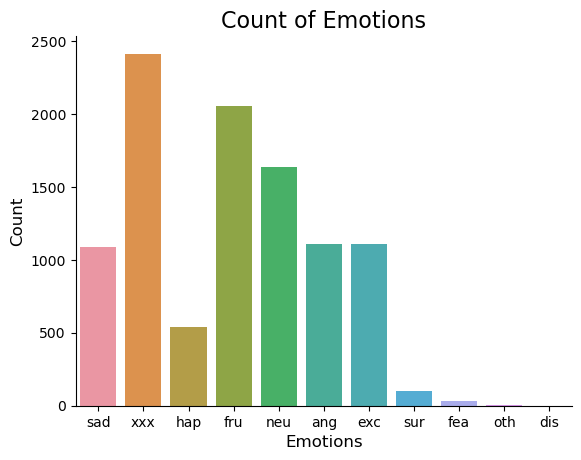

In [7]:
plt.title('Count of Emotions', size=16)
sns.countplot(x=df.emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

Let's do some consideration of the above plotted distribution of this golden labels:

- We can see how the emotion "xxx" is very common emotion (almost 2500 occurrences) but not very meaningful, our explanation behind the behavior of this golden label is that there isn't a predominant emotion in the classifications of the evaluators (excluding the self-evaluator) therefore an "xxx" gold label shows up.

- We can see that a lot of our labels are undersampled in comparison to the other labels, data augmentation could help in this cases

The strategies that we thinked of for handling the "xxx" labels are by considering them as missing values and trying to fill them by reconstruct a predominant emotion also considering the self-evaluators with more weights with respect to the other evaluators, but that would by definition modify the golden label we are provided with.

## VAD Inspection (Valence, Activation, Dominance)

In [8]:
interactive = True # CHANGE THIS TO False IN ORDER TO SEE AN INTERACTIVE PLOT
title = "VAD Inspection with reference to golden labels"

if interactive:
    fig = px.scatter_3d(df, x='valence', y='activation', z='dominance',
                        color='emotion',
                        title=title)
    fig.show()
else:
    sns.set(style = "darkgrid")

    fig = plt.figure(figsize=(15,10), dpi= 100, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111, projection = '3d')

    for e in df.emotion.unique():
        ax.scatter(df.valence[df.emotion == e], df.activation[df.emotion == e], df.dominance[df.emotion == e], label = e)

    ax.set_xlabel("valence")
    ax.set_ylabel("activation")
    ax.set_zlabel("dominance")

    ax.legend()

    plt.title(title)
    plt.show()

The only inspection for the VAD values that came in our mind is a visual inspection with reference to the golden labels and it seems that the golden labels are reflected in the VAD space with some clusters, that doesn't seem to be the case for the 'xxx' label that seems to be distributed quite randomly in this space.

# Text Classification

# Reference
- https://huggingface.co/docs/transformers/tasks/sequence_classification
- https://keras.io/examples/nlp/text_classification_from_scratch/#prepare-the-data
- https://keras.io/api/layers/preprocessing_layers/core_preprocessing_layers/text_vectorization/

# Background - Emotion evaluators

Since the final **emotion** conveyed by the text is determined by the following **evaluators**: 

1. Anger 
2. Happiness 
3. Sadness 
4. Neutral 
5. Frustration 
6. Excited 
7. Fear 
8. Surprise 
9. Disgust 
10. Other

The final **emotion** used to categorize the text is determined by the predominant evaluator. This 
lead to situations where a text lacks a predominant emotion -- Such texts were labelled `xxx`. 

# Formulation

Our approach/formulation is to use finetine a **pre-trained Sequence Classification BERT Model** to 
1. First, predict the weights (score based on frequency of evaluator) of the each of the 10 evaluators of emotion expressed by the text. 
2. Then, use these weights to determine the dominant emotion conveyed by the text.  


### Split the data in train and test dataset

In [54]:
# Split the data in to train and test

from sklearn.model_selection import train_test_split

text = df.sentence; emotion = df.emotion

X_train, X_test, y_train, y_text = train_test_split(text, emotion, test_size=0.2, shuffle=True, random_state=42)

print('Size of TRAIN dataset = ', X_train.shape)
print('Size of TEST dataset = ', X_test.shape)


Size of TRAIN dataset =  (8069,)
Size of TEST dataset =  (2018,)


### Create train and text dataframe

In [76]:
target_labels = df.columns[8:].tolist()
#print('Targets: ', *target_labels)
#print()

train_df = df.loc[X_train.index, ['sentence'] + target_labels].reset_index(drop=True)
display(train_df.head())

test_df = df.loc[X_test.index, ['sentence'] + target_labels].reset_index(drop=True)
display(test_df.head())

#  Load the dataframe as a dataset

from datasets import Dataset

dataset_train = Dataset.from_pandas(train_df)
dataset_test = Dataset.from_pandas(test_df)

dataset_train

,sentence,Anger,Happiness,Sadness,Neutral,Frustration,Excited,Fear,Surprise,Disgust,Other
0,You can't-- This is not the line for Z.X.four...,2,0,0,0,3,0,0,0,1,0
1,"Once again, I'm really- I'm really sorry.",0,0,0,2,1,0,1,0,0,2
2,"It's- It's mixed up with so many other things, I-",0,0,2,0,1,0,0,0,0,0
3,She wants grandkids. So we'll be working on th...,0,0,0,0,0,0,0,0,0,0
4,"Oh, dear, shall we like that?",0,1,0,2,0,0,0,0,0,0


,sentence,Anger,Happiness,Sadness,Neutral,Frustration,Excited,Fear,Surprise,Disgust,Other
0,I'll find out. But then after it's all over we...,0,0,0,3,0,0,0,0,0,0
1,I can't be that strong. A whole year.,0,0,3,0,1,0,0,0,0,0
2,"But you're so good with her. You know, she kno...",0,0,2,0,2,0,0,0,0,0
3,Everybody's going to come up. We're going to s...,0,2,0,0,0,1,0,0,0,0
4,Where I'm going is not the safest place on the...,0,0,0,0,3,0,0,0,0,0


Dataset({
    features: ['sentence', 'Anger', 'Happiness', 'Sadness', 'Neutral', 'Frustration', 'Excited', 'Fear', 'Surprise', 'Disgust', 'Other'],
    num_rows: 8069
})

### Define the tokenizer and Tokenize the sentence

In [202]:

from transformers import AutoTokenizer

model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


def tokenization(text):
    return tokenizer(text["sentence"])

dataset_train = dataset_train.map(tokenization, batched=True)
dataset_test = dataset_test.map(tokenization, batched=True)


from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

BATCH_SIZE = 2

tf_dataset_train = dataset_train.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols= target_labels,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
    shuffle=True
)

tf_dataset_test = dataset_test.to_tf_dataset(
    columns=["input_ids", "attention_mask"],
    label_cols= target_labels,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
    shuffle=False
)

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [105]:
for encode, labels in tf_dataset_train.take(1):
    print(encode.keys())
    print()
    print(encode['input_ids'])
    print()
    print(encode['attention_mask'])
    print()
    print(labels.keys())
    print()
    print([v for k, v in labels.items()])

dict_keys(['input_ids', 'attention_mask'])

tf.Tensor(
[[ 101 2092 1010 2065 2016 2515 2059 2008 1005 1055 1996 2203 1997 2009
  1012 2013 2014 4144 1045 2228 2016 1005 1055 6404 2032 1012  102]
 [ 101 2339 2515 1011 2339 1010 2515 2008 8572 2017 1029  102    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]], shape=(2, 27), dtype=int64)

tf.Tensor(
[[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]], shape=(2, 27), dtype=int64)

dict_keys(['Anger', 'Happiness', 'Sadness', 'Neutral', 'Frustration', 'Excited', 'Fear', 'Surprise', 'Disgust', 'Other'])

[<tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([1, 0])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 1])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 1])>, <tf.Tensor: shape=(2,), dtype=int64, numpy=array([0, 0])>, 

### Load the pretrained model

In [155]:
import tensorflow as tf
model_checkpoint

'distilbert-base-uncased'

In [208]:
from transformers import TFAutoModel

def build_model(target_labels, n_class_labels=10): 
    model = TFAutoModel.from_pretrained(model_checkpoint)

    x1 = tf.keras.layers.Input(shape=(None,), dtype=tf.int64)
    x2 = tf.keras.layers.Input(shape=(None,), dtype=tf.int64)    
    
    last_hidden_state = model(input_ids=x1, attention_mask=x2).last_hidden_state

    # Pooling layer
    x = tf.keras.layers.GlobalAveragePooling1D()(last_hidden_state) 
    
    # Dense Layer
    net_input = tf.keras.layers.Dense(n_class_labels)(x)

    # Activation Layer
    outputs = tf.keras.layers.Activation('relu')(net_input)
        
    model = tf.keras.models.Model(
        inputs={'input_ids': x1, 'attention_mask': x2}, 
        outputs={key: outputs[:, i] for i, key in enumerate(target_labels)}
        
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer)
    return model
    
model = build_model(target_labels)


'''
criterion = tf.keras.losses.MeanSquaredError()
for x, y in tf_dataset_train.take(1):
    print(x.keys(), x['input_ids'].shape, x['input_ids'].dtype)
    print(y)
    out = model(x)
    
    loss = criterion(y, out)
'''
#'''

history = model.fit(
    tf_dataset_train.take(10),
    validation_data=tf_dataset_test.take(10),
    epochs=num_epochs #,callbacks=callbacks,
)
#'''


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


10/10 [==============================] - 28s 1s/step - loss: 6.0850 - tf.__operators__.getitem_26_loss: 0.7000 - tf.__operators__.getitem_34_loss: 0.0586 - tf.__operators__.getitem_31_loss: 0.4131 - tf.__operators__.getitem_32_loss: 0.0562 - tf.__operators__.getitem_30_loss: 1.3500 - tf.__operators__.getitem_27_loss: 0.1500 - tf.__operators__.getitem_29_loss: 1.7012 - tf.__operators__.getitem_35_loss: 0.0328 - tf.__operators__.getitem_28_loss: 1.5325 - tf.__operators__.getitem_33_loss: 0.0906 - val_loss: 5.7620 - val_tf.__operators__.getitem_26_loss: 0.6000 - val_tf.__operators__.getitem_34_loss: 0.0153 - val_tf.__operators__.getitem_31_loss: 1.1500 - val_tf.__operators__.getitem_32_loss: 0.1099 - val_tf.__operators__.getitem_30_loss: 0.9008 - val_tf.__operators__.getitem_27_loss: 0.3500 - val_tf.__operators__.getitem_29_loss: 1.0500 - val_tf.__operators__.getitem_35_loss: 0.1010 - val_tf.__operators__.getitem_28_loss: 1.4850 - val_tf.__operators__.getitem_33_loss: 0.0000e+00


In [196]:
from transformers import TFAutoModel

#id2label = {1: 'Anger', 2: 'Happiness', 3: 'Sadness', 4: 'Neutral', 5: 'Frustration', 6: 'Excited', 7: 'Fear', 8: 'Surprise', 9: 'Disgust', 10: 'Other'}
id2label = {idx: label for idx, label in enumerate(target_labels)}
print('id2label: \n', id2label)
print()

label2id = {value: key for key, value in id2label.items()}
print('label2id: \n', label2id)


id2label: 
 {0: 'Anger', 1: 'Happiness', 2: 'Sadness', 3: 'Neutral', 4: 'Frustration', 5: 'Excited', 6: 'Fear', 7: 'Surprise', 8: 'Disgust', 9: 'Other'}

label2id: 
 {'Anger': 0, 'Happiness': 1, 'Sadness': 2, 'Neutral': 3, 'Frustration': 4, 'Excited': 5, 'Fear': 6, 'Surprise': 7, 'Disgust': 8, 'Other': 9}


In [200]:
from transformers import create_optimizer

num_epochs = 1
batches_per_epoch = len(dataset_train) // BATCH_SIZE
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)

model.compile(optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError())


#from transformers.keras_callbacks import PushToHubCallback
#from tensorflow.keras.callbacks import TensorBoard


model.fit(
    tf_dataset_train,
    validation_data=tf_dataset_test,
    epochs=num_epochs #,callbacks=callbacks,
)

ValueError: in user code:

    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1083, in compute_loss
        y, y_pred, sample_weight, regularization_losses=self.losses
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 236, in __call__
        y_true = self._conform_to_outputs(y_pred, y_true)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 60, in _conform_to_outputs
        struct = map_to_output_names(outputs, self._output_names, struct)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 806, in map_to_output_names
        "Found unexpected losses or metrics that do not correspond "

    ValueError: Found unexpected losses or metrics that do not correspond to any Model output: dict_keys(['Anger', 'Happiness', 'Sadness', 'Neutral', 'Frustration', 'Excited', 'Fear', 'Surprise', 'Disgust', 'Other']). Valid mode output names: ['activation_7']. Received struct is: {'Anger': <tf.Tensor 'IteratorGetNext:2' shape=(2,) dtype=int64>, 'Happiness': <tf.Tensor 'IteratorGetNext:7' shape=(2,) dtype=int64>, 'Sadness': <tf.Tensor 'IteratorGetNext:10' shape=(2,) dtype=int64>, 'Neutral': <tf.Tensor 'IteratorGetNext:8' shape=(2,) dtype=int64>, 'Frustration': <tf.Tensor 'IteratorGetNext:6' shape=(2,) dtype=int64>, 'Excited': <tf.Tensor 'IteratorGetNext:4' shape=(2,) dtype=int64>, 'Fear': <tf.Tensor 'IteratorGetNext:5' shape=(2,) dtype=int64>, 'Surprise': <tf.Tensor 'IteratorGetNext:11' shape=(2,) dtype=int64>, 'Disgust': <tf.Tensor 'IteratorGetNext:3' shape=(2,) dtype=int64>, 'Other': <tf.Tensor 'IteratorGetNext:9' shape=(2,) dtype=int64>}.


# Create  Vocabulary - INCOMPLETE!

In [ ]:
text = X_train[0]
print(text)

l = text.lower().split('.')
text = ''.join(l)
set(text.split())

# Tokenize the text with `tf.keras.layers.TextVectorization()` 

In [ ]:
import tensorflow as tf

'''
TextVectorization = tf.keras.layers.TextVectorization(
    max_tokens=None,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=None,
    pad_to_max_tokens=False,
    vocabulary=None,
    idf_weights=None,
    sparse=False,
    ragged=False,
    encoding='utf-8' #,**kwargs
)
'''

# Create the layer.  

max_features = 5000  # Maximum vocab size.
max_len = 5  # Sequence length to pad the outputs to.
embedding_dim = 4

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    pad_to_max_tokens=False,
    max_tokens=max_features, # Maximum vocab size.
    output_mode='int',
    output_sequence_length=max_len
)

# Add vocabulary file
vocabulary = ["foo", "bar", "baz"]
text_dataset = tf.data.Dataset.from_tensor_slices(vocabulary)
vectorize_layer.adapt(text_dataset.batch(64))

# Example illustration ...

In [ ]:
# Model
model = tf.keras.models.Sequential()

# Input layer 
model.add(tf.keras.Input(shape=(1,), dtype=tf.string))

# Vectorize the text
model.add(vectorize_layer)

# Embedding layer of dimension embedding_dim
model.add(tf.keras.layers.Embedding(max_features, embedding_dim))

# Make prediction ...
input_data = [["foo qux bar"], ["qux baz"]]
print('Shape = ', model.predict(input_data)[0].shape)
print()
print(
model.predict(input_data)
)

# Model

In [ ]:
def model(max_features, embedding_dim, n_class_labels = 1):
    
    from tf.keras import layers

    # A integer input for vocab indices.
    inputs = tf.keras.Input(shape=(None,), dtype="int64")

    # Next, we add a layer to map those vocab indices into a space of dimensionality
    # 'embedding_dim'.
    x = layers.Embedding(max_features, embedding_dim)(inputs)
    x = layers.Dropout(0.5)(x)

    # Conv1D + global max pooling
    x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
    x = layers.GlobalMaxPooling1D()(x)

    # We add a vanilla hidden layer:
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.5)(x)

    # We project onto a single unit output layer, and squash it with a sigmoid:
    predictions = layers.Dense(n_class_labels, activation="sigmoid", name="predictions")(x)

    model = tf.keras.Model(inputs, predictions)

    # Compile the model with binary crossentropy loss and an adam optimizer.
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return model
